In [24]:
# ============================================================
# CELL #1: Setup & Import Dependencies
# Description: Install required packages and import libraries
# ============================================================

# !pip install selenium
# !pip install pymongo
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install matplotlib
# !pip install BeautifulSoup
# !pip install python-dotenv pymongo dnspython
#!pip install wordcloud
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from pymongo import MongoClient
from datetime import datetime
import time
import re
import os
import requests
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from wordcloud import WordCloud
from collections import Counter

In [ ]:
# ============================================================
# CELL #2: Define NoFluffJobs Web Scraper Class
# Description: Class for scraping job data from NoFluffJobs
# Includes methods for HTML scraping, parsing, and MongoDB storage
# ============================================================

# load environment variable to init db
load_dotenv()


# HTML webpage scrapping
class WebScrapingNoFluff:
    def __init__(self, query_term='backend'):
        print('Initialise WebScraping instance')
        self.query_term = query_term
        self.target_url = f"https://nofluffjobs.com/pl/?lang=en&criteria=jobPosition%3D{self.query_term}"
        self.final_html = ''
        # --- init db: local db / Atlas Mongodb ---
        self._init_db()


    def _init_db(self):
        """
        You don't need .env, cause you will deploy on local db
        MONGO_MODE from .env:
        "local": connect with local mongodb
        "atlas": connect with remote mongodb
        """

        mode = os.getenv("MONGO_MODE", "local")
        db_name = os.getenv("DB_NAME", "BD_final")

        print("DB MODE: ", mode)

        if mode == "atlas":
            uri = os.getenv("ATLAS_MONGO_URI")
            if not uri:
                raise ValueError("❌ Error: ATLAS_MONGO_URI not found in .env while mode is 'atlas'")
            print(f"🌐 Connecting to Remote MongoDB Atlas...")
        else:
            uri = "mongodb://localhost:27017/"
            print(f" Connecting to Local MongoDB ({uri})...")

        try:
            self.client = MongoClient(uri)
            # test connection
            self.client.admin.command('ping')
            self.db = self.client[db_name]
            print(f"✅ Successfully connected to database: {db_name}")
        except Exception as e:
            print(f"❌ Database connection failed: {e}")
            raise

    def scrape_save_raw_to_db(self, clicks=3):
        driver = webdriver.Chrome()
        driver.get(self.target_url)
        driver.maximize_window()
        # Give you 15 seconds to accept/cancel all popup window
        wait = WebDriverWait(driver, 15)

        # Loop to click "See more offers" button 10 times
        count = 0
        while count < clicks:
            try:
                # Find the button with the nfjloadmore attribute
                load_more_btn = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[nfjloadmore]")))

                # Scroll to the button position to ensure it is in the viewport
                driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", load_more_btn)
                time.sleep(1.5)  # Allow some buffer time for scrolling

                # Click to load more
                if load_more_btn:
                    load_more_btn.click()
                count += 1
                print(f"Clicked 'See more' ({count}/{clicks})")

                # Delay for new content to load
                time.sleep(2.5)
            except Exception as e:
                print(f"Finished loading or button not found: {e}")
                break

        # C. Get the complete HTML after 10 clicks and save it
        print("All pages loaded. Capturing final HTML...")
        self.final_html = driver.page_source
        self.save_raw_to_mongodb()

        driver.quit()

    def save_raw_to_mongodb(self):
        """
        Reference your initial logic to store the raw HTML into NoSQL
        """
        # only hold one raw_json html data
        self.db.jobs_raw.drop()
        website_document = {
            'url': self.target_url,
            'content': self.final_html,
            'date': datetime.now(),
            'query_term': self.query_term
        }

        # Store in the jobs_raw collection
        result = self.db.jobs_raw.insert_one(website_document)
        print(f"Raw HTML saved to MongoDB! Document ID: {result.inserted_id}")

    # parse and split salary to min and max two value
    def parse_salary(self, salary_str):
        """
        Internal helper method: Parse salary string
        Example input: "10 000 - 15 000 PLN", "20 000 PLN", "Undisclosed"
        Output: (min_salary, max_salary)
        """
        if not salary_str or "Undisclosed" in salary_str or "Agreement" in salary_str:
            return None, None

        # Remove spaces and thousands separators
        clean_str = salary_str.replace('\xa0', '').replace(' ', '')

        # Match all digits
        numbers = re.findall(r'\d+', clean_str)

        try:
            if len(numbers) >= 2:
                # Range salary: [10000, 15000]
                return float(numbers[0]), float(numbers[1])
            elif len(numbers) == 1:
                # Fixed salary: [20000]
                return float(numbers[0]), float(numbers[0])
        except Exception:
            pass

        return None, None

    # parse job location
    def parse_location(self, card):
        """
        Internal helper method: Parse location
        """
        location_tag = card.select_one('span.posting-info__location, nfj-posting-item-city')
        if not location_tag:
            return "Unknown"

        loc_text = location_tag.get_text(strip=True)

        # Special case handling: Remote work
        if "Remote" in loc_text or "Zdalna" in loc_text:
            return "Remote"

        # Extract city name (some include '+1', filter via split)
        city = loc_text.split('+')[0].strip()
        return city

    # parse job title,company name, Min/Max Salary,Location, Jump URL and save into db
    def process_and_save(self):
        """
        Read HTML from jobs_raw and extract fields to store in jobs_processed
        extract raw html and parse fields then save into
        """
        # Get the most recently scraped HTML document
        raw_data = self.db.jobs_raw.find_one(sort=[("date", -1)])
        if not raw_data:
            print("No raw data found in MongoDB!")
            return

        soup = BeautifulSoup(raw_data['content'], 'html.parser')

        # Locate all job cards
        postings = soup.select('a.posting-list-item')
        print(f"Found {len(postings)} job postings in HTML.")

        processed_list = []
        base_domain = "https://nofluffjobs.com"  # Used to concatenate the full URL

        for post in postings:
            try:
                # --- Field 1: Job Title ---
                title_el = post.select_one('h3.posting-title__position, .posting-title__can-hide')
                if title_el:
                    # Find and remove any potential "NEW" tags or other badges
                    # NFJ's badge class names usually contain title-badge
                    for badge in title_el.select('.title-badge, .title-badge--new'):
                        badge.decompose()
                    job_title = title_el.get_text(strip=True)
                else:
                    job_title = "N/A"
                # print('JOB TITLE:', job_title)

                # --- Field 2: Company Name ---
                company_el = post.select_one('span.d-block, .company-name')
                company_name = company_el.get_text(strip=True) if company_el else "N/A"

                # --- Fields 3 & 4: Min/Max Salary ---
                salary_el = post.select_one('span.text-truncate, nfj-posting-item-salary')
                salary_str = salary_el.get_text(strip=True) if salary_el else ""
                min_sal, max_sal = self.parse_salary(salary_str)

                # --- Field 5: Location ---
                location = self.parse_location(post)

                # --- Field 6: Jump URL ---
                # Get relative path from the <a> tag's href attribute and concatenate domain
                relative_url = post.get('href')
                jump_url = base_domain + relative_url if relative_url else "N/A"

                # Construct document
                job_doc = {
                    "source": "nofluffjobs",
                    'job_title': job_title,
                    'company_name': company_name,
                    'min_salary': min_sal,
                    'max_salary': max_sal,
                    'location': location,
                    'jump_url': jump_url,  # Add to the document
                    'processed_at': datetime.now(),
                    'query_term': raw_data['query_term']
                }

                processed_list.append(job_doc)

            except Exception as e:
                print(f"Error parsing a single post: {e}")
                continue

        # Batch save to the new collection
        if processed_list:
            self.db.jobs_processed.drop()
            self.db.jobs_processed.insert_many(processed_list)
            print(f"Successfully processed {len(processed_list)} jobs and saved to 'jobs_processed'.")

    # scrape the job detail page and add must-have skill set into each job
    def scrape_must_have_skills(self, limit=0):
        driver = webdriver.Chrome()
        driver.maximize_window()
        wait = WebDriverWait(driver, 15)


        jobs = list(self.db.jobs_processed.find().limit(limit))
        print(f"Scraping Must-have skills for {len(jobs)} jobs")

        for job in jobs:
            url = job.get("jump_url")
            if not url:
                continue

            try:
                driver.get(url)
                time.sleep(2)  # wait for page to render

                soup = BeautifulSoup(driver.page_source, "html.parser")
                must_section = soup.select_one('section[branch="musts"]')

                skills = []
                if must_section:
                    skill_tags = must_section.select('span[id^="item-tag-"]')
                    for tag in skill_tags:
                        skills.append(tag.get_text(strip=True).lower())

                # Update MongoDB document
                self.db.jobs_processed.update_one(
                    {"_id": job["_id"]},
                    {"$set": {"must_have_skills": skills}}
                )

                print(f"✔ {job['job_title']} → {skills}")

            except Exception as e:
                print(f"❌ Error scraping {url} : {e}")

        driver.quit()
        print("Finished scraping Must-have skills.")

In [ ]:
# ============================================================
# CELL #3: Execute NoFluffJobs Scraper
# Description: Run the web scraper to collect raw HTML data
# from NoFluffJobs and save it to MongoDB
# ============================================================

scraperNoFluff = WebScrapingNoFluff(query_term='backend')
scraperNoFluff.scrape_save_raw_to_db()


In [5]:
# ============================================================
# CELL #4: Parse and Extract Structured Job Data
# Description: Extract job title, company, salary, location
# from raw HTML and save to MongoDB jobs_processed collection
# ============================================================

scraperNoFluff.process_and_save()

Found 80 job postings in HTML.
Successfully processed 80 jobs and saved to 'jobs_processed'.


In [6]:
# ============================================================
# CELL #5: Scrape Must-Have Skills
# Description: Visit each job detail page and extract
# the must-have skills list, adding to MongoDB documents
# ============================================================

scraperNoFluff.scrape_must_have_skills()

Scraping Must-have skills for 80 jobs
✔ Senior Backend Engineer → ['java', 'spring boot/cloud 3.3']
✔ Senior Backend Developer (NestJS + TypeScript) → ['typescript', 'nestjs']
✔ Senior Backend Developer → ['.net', 'microsoft azure', 'mvc', '.net', 'c#', 'ai', 'ms sql']
✔ Engineering Lead – Backend Architecture (Java, Distributed Systems & Security) → ['java', 'ai', 'oauth2', 'aws', 'kafka']
✔ Backend developer (Java & Spring Boot) → ['java', 'spring boot', 'reactive extensions library for javascript', 'rest api', 'microservices architecture', 'apache kafka', 'gradle', 'git', 'spring', 'unit testing', 'integration test', 'github', 'jira']
✔ Engineering Lead – Backend Architecture (Java, Distributed Systems & Security) → ['java', 'ai', 'oauth2', 'aws', 'kafka']
✔ Senior Java Backend Engineer (Core Java, Trading Systems) → ['java', 'core java', 'algorithms', 'data structures']
✔ Java Software Engineer - Backend (all genders) → ['java', 'postgresql', 'mongodb', 'microservices', 'message qu

In [12]:
# ============================================================
# CELL #6: Define JustJoin.it API Scraper Class
# Description: Class for scraping job data from JustJoin.it
# using their public API (faster than HTML scraping)
# ============================================================

class WebScrapingJustJoin:
    def __init__(self, query_term="backend"):
        print("Initialise WebScrapingJustJoin instance")
        self.query_term = query_term
        self.api_url = (
            "https://api.justjoin.it/v2/user-panel/offers/by-cursor"
            "?cityRadiusKm=30"
            "&currency=pln"
            "&from=0"
            "&itemsCount=100"
            f"&keywords[]={query_term.replace(' ', '%20')}"
            "&orderBy=DESC"
            "&sortBy=published"
        )
        self._init_db()

    def _init_db(self):
        mode = os.getenv("MONGO_MODE", "local")
        db_name = os.getenv("DB_NAME", "BD_final")

        if mode == "atlas":
            uri = os.getenv("ATLAS_MONGO_URI")
        else:
            uri = "mongodb://localhost:27017/"

        self.client = MongoClient(uri)
        self.db = self.client[db_name]
        print("✅ JustJoin connected to DB")

    # ---- salary normalization (matches NoFluff logic) ----
    def normalize_salary(self, emp):
        if not emp or emp.get("from") is None:
            return None, None

        from_sal = emp.get("from")
        to_sal = emp.get("to")
        unit = emp.get("unit")  # hour / day / month

        if unit == "hour":
            return from_sal * 160, to_sal * 160
        if unit == "day":
            return from_sal * 20, to_sal * 20

        return from_sal, to_sal  # month

    def scrape_and_process(self):
        import requests

        processed = []
        items_per_request = 100   # max jobs per API request
        max_items = 300           # total jobs we want

        for start in range(0, max_items, items_per_request):
            paged_url = (
                "https://api.justjoin.it/v2/user-panel/offers/by-cursor"
                "?cityRadiusKm=30"
                "&currency=pln"
                f"&from={start}"
                f"&itemsCount={items_per_request}"
                f"&keywords[]={self.query_term.replace(' ', '%20')}"
                "&orderBy=DESC"
                "&sortBy=published"
            )

            response = requests.get(paged_url)
            raw = response.json()

            for job in raw.get("data", []):
                emp = job.get("employmentTypes", [{}])[0]
                min_sal, max_sal = self.normalize_salary(emp)

                processed.append({
                    "source": "justjoin",
                    "job_title": job.get("title"),
                    "company_name": job.get("companyName"),
                    "min_salary": min_sal,
                    "max_salary": max_sal,
                    "location": job.get("city"),
                    "jump_url": f"https://justjoin.it/offers/{job.get('slug')}",
                    "must_have_skills": [
                        skill.lower() for skill in job.get("requiredSkills", [])
                    ],
                    "processed_at": datetime.now(),
                    "query_term": self.query_term

                })
        print(f"✅ Saved {len(processed)} JustJoin jobs")

        self.db.jobs_processed_jj.drop()
        self.db.jobs_processed_jj.insert_many(processed)


In [13]:
# ============================================================
# CELL #7: Execute JustJoin.it API Scraper
# Description: Scrape jobs from JustJoin.it and save to
# MongoDB jobs_processed_jj collection (includes skills)
# ============================================================

jj_scraper = WebScrapingJustJoin(query_term="backend")
jj_scraper.scrape_and_process()

Initialise WebScrapingJustJoin instance
✅ JustJoin connected to DB
✅ Saved 300 JustJoin jobs


In [ ]:
# ============================================================
# CELL #8: Load Jobs from Both Sources into DataFrame
# Description: Retrieves job data from both NoFluffJobs and
# JustJoin.it collections, combines them into a pandas DataFrame
# with standardized skills formatting
# ============================================================

from pymongo import MongoClient
import pandas as pd

client = MongoClient("mongodb://localhost:27017/")
db = client["BD_final"]

# combine both sources into one dataset
jobs_nf = list(db.jobs_processed.find({"must_have_skills": {"$exists": True, "$ne": []}}))
jobs_jj = list(db.jobs_processed_jj.find({"must_have_skills": {"$exists": True, "$ne": []}}))

jobs = jobs_nf + jobs_jj

# Preserve all relevant metadata, including jump_url and query_term
df = pd.DataFrame(jobs)[[
    "job_title",
    "company_name",
    "must_have_skills",
    "min_salary",
    "max_salary",
    "source"
]]

# Drop rows with empty or missing skills
df = df[df["must_have_skills"].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()

# Lowercase all skills and join into a single string per job
df["skills_text"] = df["must_have_skills"].apply(lambda x: " ".join([s.lower() for s in x]))

print(f"Loaded {len(df)} jobs with skills")

In [ ]:
# ============================================================
# CELL #9: Skill Frequency Analysis with MongoDB Aggregation
# Description: Performs advanced aggregation pipeline to analyze
# skill frequency, salary ranges, and job title distribution
# across both job sources
# ============================================================

from collections import defaultdict

# Connect to MongoDB (adjust the connection string as needed)
client = MongoClient('mongodb://localhost:27017/')
db = client['BD_final']

# Define the pipeline without the unionWith operation
pipeline = [
    # 1. Remove jobs without skills
    {
        "$match": {
            "must_have_skills": {"$exists": True, "$ne": []}
        }
    },

    # 2. Explode skills array → one document per skill
    {
        "$unwind": "$must_have_skills"
    },

    # 3. Group by skill
    {
        "$group": {
            "_id": "$must_have_skills",

            # how many job postings mention this skill
            "job_count": {"$sum": 1},

            # salary context (Mongo ignores nulls automatically)
            "avg_min_salary": {"$avg": "$min_salary"},
            "avg_max_salary": {"$avg": "$max_salary"},

            # keep example values (useful for inspection)
            "example_titles": {"$addToSet": "$job_title"}
        }
    },

    # 4. Add derived fields
    {
        "$addFields": {
            "unique_titles_count": {"$size": "$example_titles"}
        }
    }
]

# Run pipeline on each collection separately
skill_analysis_1 = list(db.jobs_processed.aggregate(pipeline))
skill_analysis_2 = list(db.jobs_processed_jj.aggregate(pipeline))

# Combine results properly by merging skills
combined_skills = defaultdict(lambda: {
    "job_count": 0,
    "salary_sum_min": 0,
    "salary_sum_max": 0,
    "salary_count": 0,
    "example_titles": set()
})

# Process first collection results
for skill in skill_analysis_1:
    skill_name = skill["_id"]
    combined_skills[skill_name]["job_count"] += skill["job_count"]

    # Handle salary data
    if "avg_min_salary" in skill and skill["avg_min_salary"] is not None:
        combined_skills[skill_name]["salary_sum_min"] += skill["avg_min_salary"] * skill["job_count"]
        combined_skills[skill_name]["salary_count"] += skill["job_count"]

    if "avg_max_salary" in skill and skill["avg_max_salary"] is not None:
        combined_skills[skill_name]["salary_sum_max"] += skill["avg_max_salary"] * skill["job_count"]

    # Add example titles
    combined_skills[skill_name]["example_titles"].update(skill["example_titles"])

# Process second collection results
for skill in skill_analysis_2:
    skill_name = skill["_id"]
    combined_skills[skill_name]["job_count"] += skill["job_count"]

    # Handle salary data
    if "avg_min_salary" in skill and skill["avg_min_salary"] is not None:
        combined_skills[skill_name]["salary_sum_min"] += skill["avg_min_salary"] * skill["job_count"]
        combined_skills[skill_name]["salary_count"] += skill["job_count"]

    if "avg_max_salary" in skill and skill["avg_max_salary"] is not None:
        combined_skills[skill_name]["salary_sum_max"] += skill["avg_max_salary"] * skill["job_count"]

    # Add example titles
    combined_skills[skill_name]["example_titles"].update(skill["example_titles"])

# Convert to final format
skill_analysis = []
for skill_name, data in combined_skills.items():
    skill_doc = {
        "_id": skill_name,
        "job_count": data["job_count"],
        "example_titles": list(data["example_titles"]),
        "unique_titles_count": len(data["example_titles"])
    }

    # Calculate average salaries if data exists
    if data["salary_count"] > 0:
        skill_doc["avg_min_salary"] = data["salary_sum_min"] / data["salary_count"]
        skill_doc["avg_max_salary"] = data["salary_sum_max"] / data["salary_count"]

    skill_analysis.append(skill_doc)

# Sort by job count (most in-demand skills first)
skill_analysis.sort(key=lambda x: x["job_count"], reverse=True)

# Quick inspection
for doc in skill_analysis[:10]:
    print(doc)

In [16]:
# ============================================================
# CELL #10: TF-IDF Vectorization of Skills
# Description: Transforms job skills into a numerical matrix using
# TF-IDF vectorization for subsequent analysis and modeling
# ============================================================

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    min_df=0.015,   # ignore very rare skills
    max_df=0.99
)

X_skills = vectorizer.fit_transform(df["skills_text"])
print("Skill matrix shape:", X_skills.shape)

Skill matrix shape: (380, 108)


In [17]:
# ============================================================
# CELL #11: Determine Optimal Number of Clusters
# Description: Uses elbow method and silhouette scores to identify
# the optimal number of skill clusters for backend job market
# ============================================================

# Estimate reasonable number of clusters for backend job skills
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Count unique skill combinations
df["skills_tuple"] = df["must_have_skills"].apply(lambda x: tuple(sorted(x)))
skill_combos = df.groupby("skills_tuple").size().sort_values(ascending=False)

print(f"Total jobs: {len(df)}")
print(f"Total unique skill combinations: {len(skill_combos)}")
print("Top 10 most common skill combinations:")
print(skill_combos.head(10))

# Heuristic for number of clusters
heuristic_k = int(np.sqrt(len(df)/2))
print(f"\nHeuristic suggestion for max number of clusters: {heuristic_k}")

# Silhouette scores for k=2 to 9
print("\nSilhouette scores for different k:")
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_skills)
    score = silhouette_score(X_skills, labels)
    print(f"k={k}, silhouette score={score:.3f}")

print("\n✅ Use this information to pick an interpretable k")

Total jobs: 380
Total unique skill combinations: 333
Top 10 most common skill combinations:
skills_tuple
(backend, databases, linux / unix, python)                                                                                7
(node.js, typescript)                                                                                                     6
(ai, backend, cloud, data science, docker, frontend, generative ai, llm, python, software development)                    4
(.net, apache kafka, c#, ci/cd, clean code, cloud, microservices, rabbitmq, rest api)                                     4
(api management, aws, ci/cd, databricks, github, node.js, project management, python, snowflake, technical leadership)    3
(.net, go, nosql, postgresql, rust)                                                                                       3
(aws, nestjs, node.js, react, team management, typescript)                                                                3
(c++, java, javascript)    

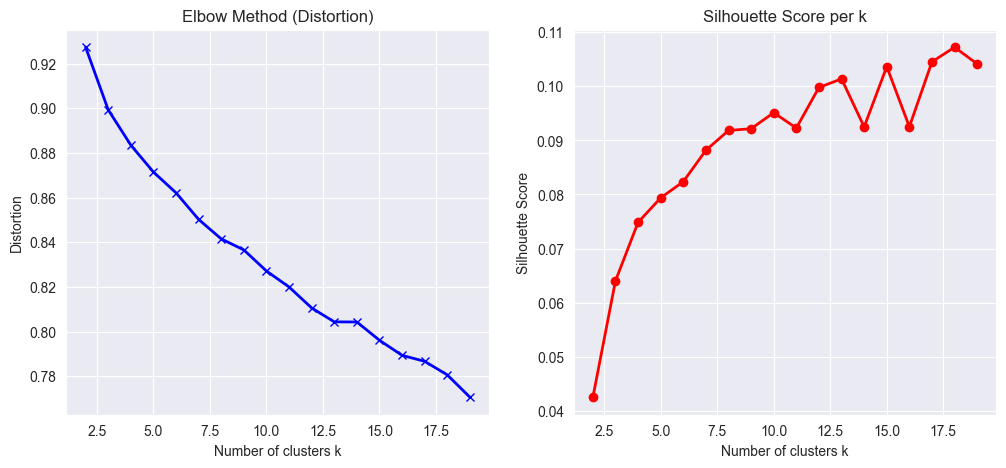

In [18]:
# ============================================================
# CELL #12: Determine Optimal Number of Clusters
# Description: Uses elbow method and silhouette scores to identify
# the optimal number of skill clusters for backend job market
# ============================================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

# Standardize X_skills (optional, can use as-is since TF-IDF is normalized)
X_dense = X_skills.toarray()

K_range = range(2, 20)
distortions = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_dense)

    # distortion: mean distance to closest centroid
    dist = np.mean(np.min(cdist(X_dense, kmeans.cluster_centers_, 'euclidean'), axis=1))
    distortions.append(dist)

    sil = silhouette_score(X_dense, labels)
    silhouette_scores.append(sil)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, distortions, 'bx-', linewidth=2)
plt.xlabel("Number of clusters k")
plt.ylabel("Distortion")
plt.title("Elbow Method (Distortion)")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, 'ro-', linewidth=2)
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score per k")

plt.show()

In [19]:
# ============================================================
# CELL #13: Apply K-Means Clustering and Analyze Skill Groups
# Description: Implements final clustering with optimal k=12,
# identifies key skills in each cluster, and provides examples
# of representative job titles for each skill group
# ============================================================

import numpy as np

# Use the optimal k=12 based on silhouette analysis
k_optimal = 12

# Apply KMeans with the optimal k
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_dense)

# Get cluster sizes
cluster_sizes = df["cluster"].value_counts().sort_index()
print(f"Jobs per cluster:")
for i in range(k_optimal):
    print(f"Cluster {i}: {cluster_sizes.get(i, 0)} jobs")

# Extract feature names from the vectorizer
terms = vectorizer.get_feature_names_out()

# Display top skills for each cluster
print("\nTop skills per cluster:")
for cluster_id in range(k_optimal):
    center = kmeans.cluster_centers_[cluster_id]
    top_idx = np.argsort(center)[-10:][::-1]
    top_skills = [terms[i] for i in top_idx]

    # Get the weights for the top skills
    top_weights = center[top_idx]

    print(f"\nCluster {cluster_id} ({cluster_sizes.get(cluster_id, 0)} jobs):")
    # Print skills with their weights
    for skill, weight in zip(top_skills, top_weights):
        print(f"  - {skill}: {weight:.3f}")

    # Show example job titles from this cluster
    if cluster_id in cluster_sizes.index:
        examples = df[df["cluster"] == cluster_id]["job_title"].sample(min(3, cluster_sizes[cluster_id])).tolist()
        print(f"  Example jobs: {examples}")

print("\n✅ Skill clusters identified with their most representative technologies")

Jobs per cluster:
Cluster 0: 19 jobs
Cluster 1: 57 jobs
Cluster 2: 55 jobs
Cluster 3: 33 jobs
Cluster 4: 27 jobs
Cluster 5: 47 jobs
Cluster 6: 27 jobs
Cluster 7: 44 jobs
Cluster 8: 27 jobs
Cluster 9: 17 jobs
Cluster 10: 11 jobs
Cluster 11: 16 jobs

Top skills per cluster:

Cluster 0 (19 jobs):
  - python: 0.499
  - ai: 0.211
  - llm: 0.121
  - postgresql: 0.103
  - gcp: 0.101
  - docker: 0.076
  - agile: 0.074
  - aws: 0.073
  - cloud: 0.073
  - development: 0.073
  Example jobs: ['Backend Data Engineer', 'Python Developer', 'Senior Python Back-End Engineer with Gen AI experience']

Cluster 1 (57 jobs):
  - js: 0.414
  - node: 0.287
  - typescript: 0.269
  - react: 0.111
  - aws: 0.086
  - nest: 0.084
  - postgresql: 0.076
  - next: 0.057
  - javascript: 0.054
  - api: 0.049
  Example jobs: ['Senior Backend/AI Engineer', 'Mid/Senior Backend Developer - Retail Media Platforms (NestJS, NodeJS, and TypeScript)', 'Senior Backend Engineer - E-commerce Integrations Team']

Cluster 2 (55 jobs

Removed 8 outliers from 257 jobs with salary data
Salary Statistics by Cluster (sorted by median salary):
         count          mean   median           std      min      max
cluster                                                              
10           9  25885.333333  28600.0  12281.801008   6800.0  36800.0
5           33  25297.757576  25200.0   6726.173247   6880.0  37500.0
8           17  23251.764706  25000.0   6022.789258   5450.0  31200.0
1           47  23114.085106  24000.0   5856.457320   5250.0  32550.0
2           42  22893.678571  24000.0   8104.740109   5400.0  38640.0
11          10  23676.000000  23880.0   5551.414635  14800.0  32800.0
7           23  22815.652174  22260.0   7453.021246   7250.0  38750.0
0           14  19562.464286  21930.0   8173.621739   5600.0  29947.5
6           14  22398.571429  21480.0   6005.072032  12000.0  32250.0
9           12  19080.000000  21000.0   4917.656500   8500.0  23500.0
4           21  19407.619048  19000.0   6676.505002   

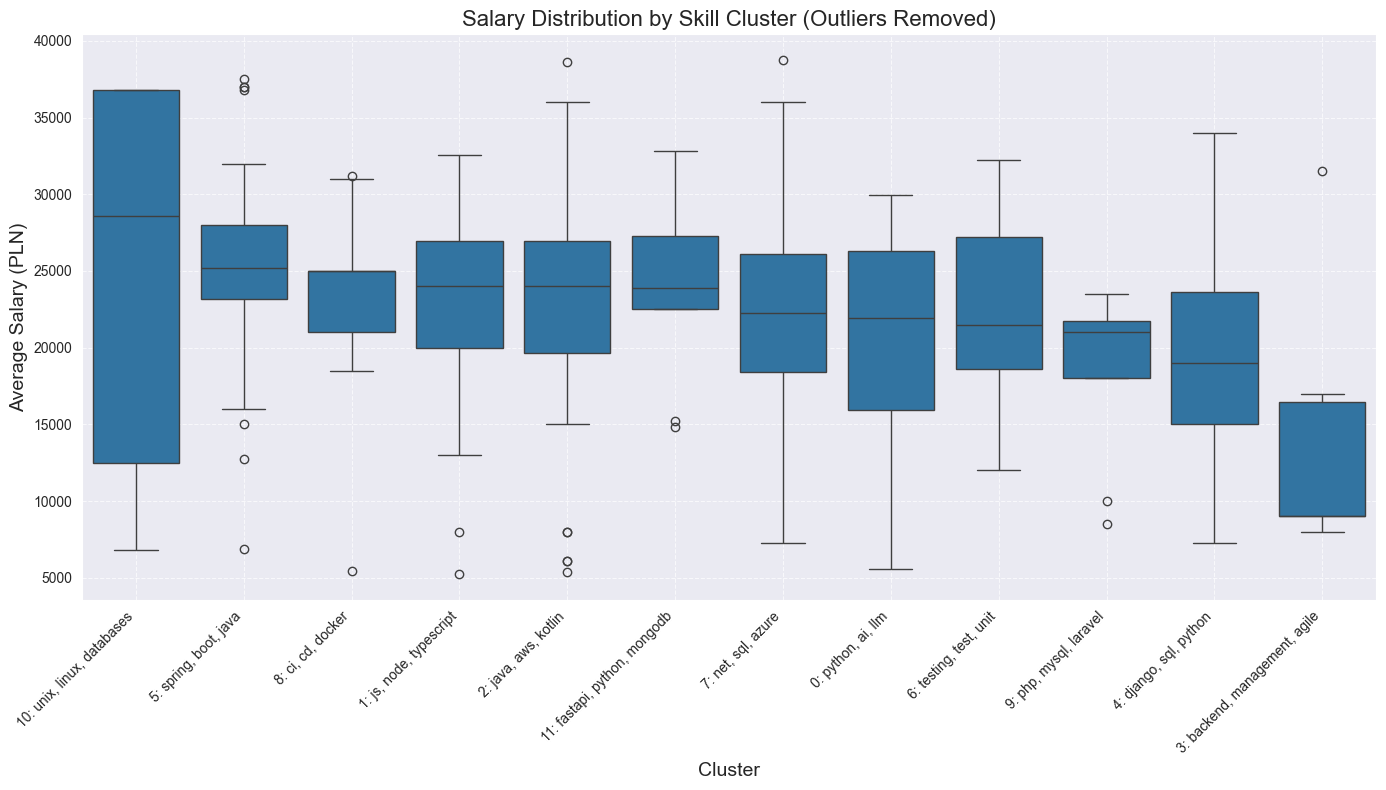


Highest paying cluster (10):
Top skills: unix, linux, databases, python, backend, jvm, rest, api, go, soap
Median salary: 28600.00 PLN

Lowest paying cluster (3):
Top skills: backend, management, agile, frontend, security, ci, cd, java, cloud, web
Median salary: 9000.00 PLN

✅ Salary analysis complete - identified high-value skill combinations


In [20]:
# ============================================================
# CELL #14: Salary Analysis by Cluster
# Description: Analyzes salary distributions across skill clusters
# to identify high-value skill combinations in the job market
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Filter to jobs with salary data
salary_df = df[df["min_salary"].notna() & df["max_salary"].notna()].copy()

# Calculate average salary for each job
salary_df["avg_salary"] = (salary_df["min_salary"] + salary_df["max_salary"]) / 2

# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR  # Standard outlier threshold

    return df[df[column] <= upper_bound]

# Apply outlier removal
salary_df_filtered = remove_outliers(salary_df, "avg_salary")
print(f"Removed {len(salary_df) - len(salary_df_filtered)} outliers from {len(salary_df)} jobs with salary data")

# 1. Summary statistics by cluster using filtered data
cluster_salary_stats = salary_df_filtered.groupby("cluster")["avg_salary"].agg(
    ["count", "mean", "median", "std", "min", "max"]
).sort_values(by="median", ascending=False)

print("Salary Statistics by Cluster (sorted by median salary):")
print(cluster_salary_stats)

# 2. Visualize salary distributions with filtered data
plt.figure(figsize=(14, 8))
sns.boxplot(x="cluster", y="avg_salary", data=salary_df_filtered, order=cluster_salary_stats.index)
plt.title("Salary Distribution by Skill Cluster (Outliers Removed)", fontsize=16)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Average Salary (PLN)", fontsize=14)
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', alpha=0.7)

# Add cluster labels below the x-axis
cluster_labels = []
for cluster_id in cluster_salary_stats.index:
    # Get top 3 skills for this cluster
    center = kmeans.cluster_centers_[cluster_id]
    top_idx = np.argsort(center)[-3:][::-1]
    top_skills = [terms[i] for i in top_idx]
    cluster_labels.append(f"{cluster_id}: {', '.join(top_skills)}")

plt.xticks(range(len(cluster_labels)), cluster_labels, rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3. Identify highest and lowest paying clusters
highest_paying = cluster_salary_stats.index[0]
lowest_paying = cluster_salary_stats.index[-1]

print(f"\nHighest paying cluster ({highest_paying}):")
top_skills_highest = [terms[i] for i in np.argsort(kmeans.cluster_centers_[highest_paying])[-10:][::-1]]
print(f"Top skills: {', '.join(top_skills_highest)}")
print(f"Median salary: {cluster_salary_stats.loc[highest_paying, 'median']:.2f} PLN")

print(f"\nLowest paying cluster ({lowest_paying}):")
top_skills_lowest = [terms[i] for i in np.argsort(kmeans.cluster_centers_[lowest_paying])[-10:][::-1]]
print(f"Top skills: {', '.join(top_skills_lowest)}")
print(f"Median salary: {cluster_salary_stats.loc[lowest_paying, 'median']:.2f} PLN")

print("\n✅ Salary analysis complete - identified high-value skill combinations")

In [ ]:
# ============================================================
# CELL #15: Skill Gap and Demand Analysis
# Description: Identifies valuable skills that appear predominantly
# in higher-paying clusters and analyzes demand vs. compensation
# ============================================================

# Calculate skill importance across clusters
skill_importance = {}

# Extract feature names from the vectorizer
terms = vectorizer.get_feature_names_out()

# For each cluster, calculate importance of each skill
for cluster_id in range(k_optimal):
    # Get the cluster center
    center = kmeans.cluster_centers_[cluster_id]

    # If this is the first cluster, initialize the dictionary with all skills
    if cluster_id == 0:
        for i, skill in enumerate(terms):
            skill_importance[skill] = [0] * k_optimal

    # Store the importance (weight) of each skill in this cluster
    for i, skill in enumerate(terms):
        skill_importance[skill][cluster_id] = center[i]

# Now skill_importance is a dictionary where:
# - Keys are skill names
# - Values are lists of importance scores for each cluster

print(f"Skill importance calculated for {len(skill_importance)} skills across {k_optimal} clusters")

# Optional: You can also calculate overall importance by summing or averaging across clusters
overall_importance = {skill: sum(scores) for skill, scores in skill_importance.items()}

# Example: Show top 10 skills by overall importance
top_skills = sorted(overall_importance.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 skills by overall importance:")
for skill, score in top_skills:
    print(f"  - {skill}: {score:.3f}")

# Use the actual number of clusters from your data
k_optimal = len(skill_importance[list(skill_importance.keys())[0]])
print(f"Using k_optimal = {k_optimal}")

# 1. Calculate skill importance across all clusters
for term_idx, term in enumerate(terms):
    # Get the weight of this skill in each cluster
    weights = [center[term_idx] for center in kmeans.cluster_centers_]
    skill_importance[term] = weights

# Convert to DataFrame for easier analysis
skill_df = pd.DataFrame(skill_importance).T
skill_df.columns = [f"cluster_{i}" for i in range(k_optimal)]

# 2. Calculate correlation between skill presence and cluster salary
cluster_median_salaries = cluster_salary_stats["median"].to_dict()
salary_correlation = {}

for skill in skill_df.index:
    # Weight each cluster's importance by its median salary
    weighted_importance = sum(
        skill_df.loc[skill, f"cluster_{c}"] * cluster_median_salaries.get(c, 0)
        for c in range(k_optimal)
    )
    salary_correlation[skill] = weighted_importance

# Sort skills by salary correlation
salary_corr_df = pd.DataFrame({
    "skill": list(salary_correlation.keys()),
    "salary_correlation": list(salary_correlation.values())
}).sort_values("salary_correlation", ascending=False)

# 3. Calculate skill demand (frequency across all jobs)
skill_demand = {}
# Use the same set of skills as in salary_correlation to ensure consistency
for skill in salary_correlation.keys():
    # Count jobs that require this skill
    demand = df["skills_text"].str.contains(r'\b' + skill + r'\b').sum()
    skill_demand[skill] = demand / len(df)  # Normalize by total jobs

# 4. Combine salary correlation and demand
skill_analysis = salary_corr_df.copy()
skill_analysis["demand"] = skill_analysis["skill"].map(skill_demand)

# Filter to skills with meaningful presence (at least 5% of jobs)
skill_analysis = skill_analysis[skill_analysis["demand"] >= 0.05].reset_index(drop=True)

# Define the t_values function to sort the skill_analysis DataFrame
def t_values(column_name, ascending=True):
    return skill_analysis.sort_values(by=column_name, ascending=ascending)

# 5. Identify high-value skills (high salary correlation, lower demand)
print("Top 20 High-Value Skills (High Salary Correlation):")
print(skill_analysis.head(20))

# 6. Visualize skill value vs. demand with smart label placement for top 20 high-value skills
import matplotlib.patheffects as PathEffects

plt.figure(figsize=(14, 10))

# Create a scatter plot with color gradient based on salary correlation for all points
scatter = plt.scatter(
    skill_analysis["demand"],
    skill_analysis["salary_correlation"],
    alpha=0.8,
    c=skill_analysis["salary_correlation"],  # Color by salary correlation
    cmap='viridis',                          # Use a color gradient
    s=80                                     # Slightly larger points
)

# Add a color bar to show the salary correlation scale
plt.colorbar(scatter, label="Salary Correlation")

# Get the top 20 skills by salary correlation
top20_skills = t_values("salary_correlation", ascending=False).head(20)

# Highlight the top 20 skills with a distinct border
for i, row in top20_skills.iterrows():
    plt.scatter(
        row["demand"],
        row["salary_correlation"],
        s=150,              # Larger size
        facecolors='none',  # Transparent fill
        edgecolors='white', # White border
        linewidths=2,       # Thicker border
        zorder=10           # Ensure it's on top
    )

# Add labels with varying offsets to reduce overlap
offsets = [(7, 0), (7, 10), (7, -10), (-40, 0), (-40, 10), (-40, -10),
           (7, 20), (7, -20), (-40, 20), (-40, -20)]

for i, row in top20_skills.iterrows():
    # Use different offsets for different points
    offset = offsets[i % len(offsets)]

    # Draw a line from the data point to the label if offset is significant
    if abs(offset[0]) > 10 or abs(offset[1]) > 5:
        plt.annotate(
            '',
            xy=(row["demand"], row["salary_correlation"]),
            xytext=(row["demand"] + offset[0]/500, row["salary_correlation"] + offset[1]/500),
            arrowprops=dict(arrowstyle='-', color='white', lw=1, alpha=0.7),
            zorder=9
        )

    # Add the label
    plt.annotate(
        row["skill"],
        xy=(row["demand"], row["salary_correlation"]),
        xytext=offset,
        textcoords="offset points",
        fontsize=11,
        fontweight='bold',
        color='white',
        path_effects=[
            PathEffects.withStroke(linewidth=3, foreground='black')
        ],
        va='center',
        zorder=11
    )

plt.title("Top 20 High-Value Skills by Salary Correlation", fontsize=16)
plt.xlabel("Demand (% of Jobs Requiring Skill)", fontsize=14)
plt.ylabel("Salary Correlation", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Just print the completion message without the redundant list
print("\n✅ Skill gap analysis complete - identified high-value skills with varying demand")


The most important 15 skills



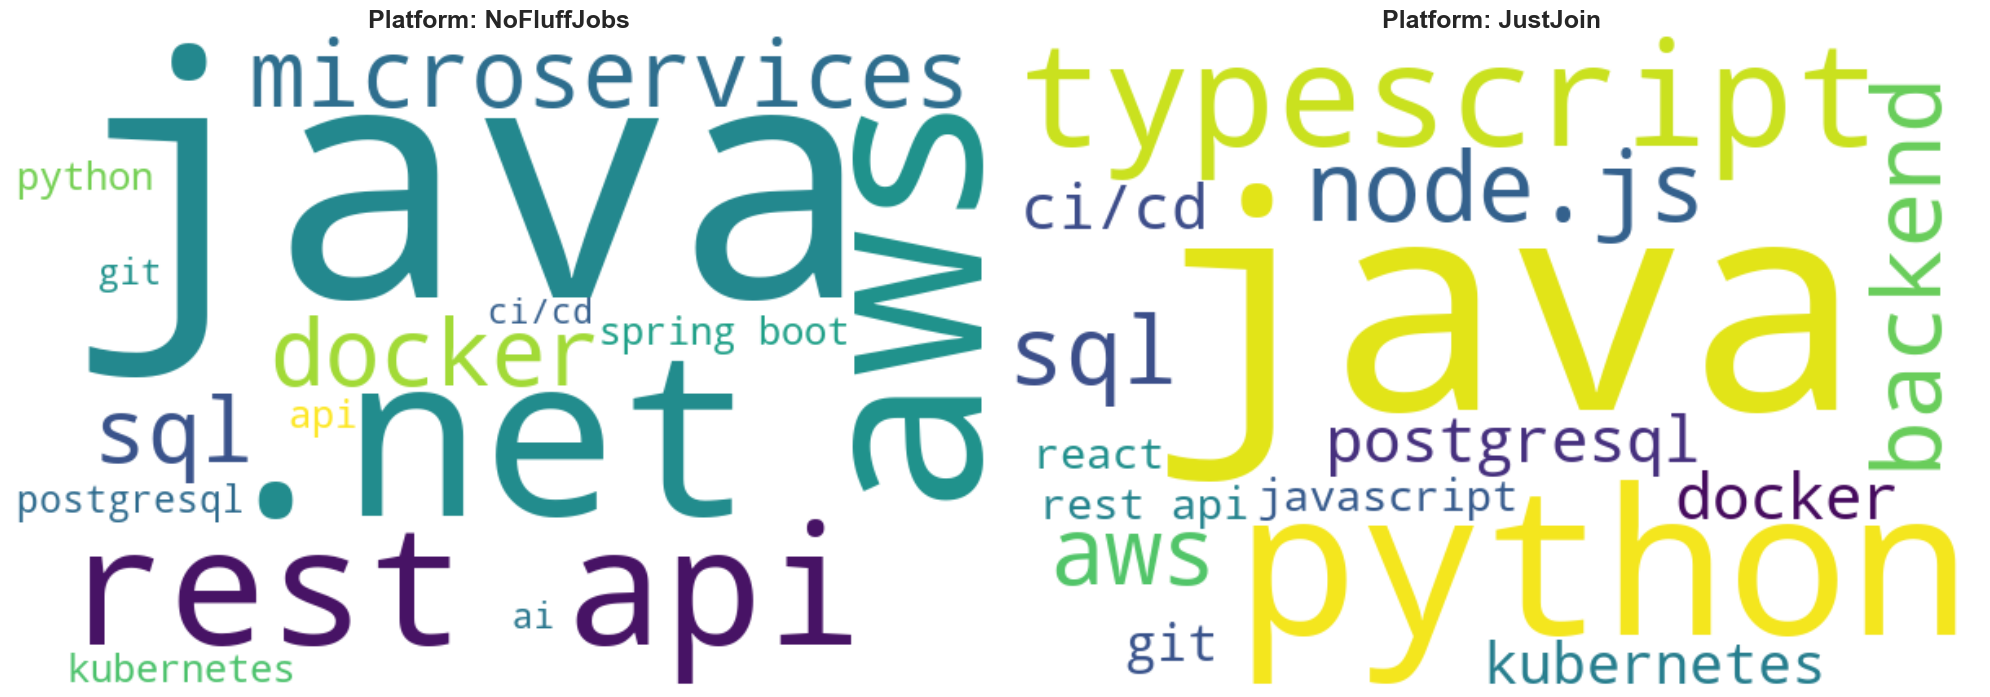

Comparison chart saved successfully to: combined_skills_comparison.png


In [32]:
# ============================================================
# CELL #16: Visualize job data with Word Cloud by platform
# fetch job market data from MongoDB, extract required technical skills,
# and generate comparative word cloud visualizations to highlight key industry demands across different platforms.
# ============================================================
class JobDataCloudImageGenerator:
    def __init__(self, db_client):
        """
        Initialize the visualization class.
        :param db_client: An active MongoDB database instance.
        """
        self.db = db_client
        # Standard configuration for WordCloud generation
        self.max_words=15
        self.wc_params = {
            'width': 600,
            'height': 400,
            'background_color': 'white',
            'colormap': 'viridis'
        }

    def _get_data_from_db(self, platform_name):
        """
        Internal method: Fetches raw data from MongoDB based on platform enum
        and converts it into a pandas DataFrame.
        """
        if platform_name == CollectionEnum.JUST_JOIN:
            data = list(self.db.jobs_processed_jj.find())
        elif platform_name == CollectionEnum.NO_FLUFF_JOBS:
            data = list(self.db.jobs_processed.find())
        else:
            raise NameError(f"Unknown collection name for: {platform_name}")

        return pd.DataFrame(data)

    def _extract_skills(self, df):
        """
        Internal method: Cleans and extracts the list of skills from the DataFrame.
        Handles both list-type and string-type entries in 'must_have_skills' columns.
        """
        skill_cols = [col for col in df.columns if 'must_have_skills' in col]
        raw_skills = df[skill_cols].values.flatten()

        all_skills = []
        for item in raw_skills:
            if isinstance(item, (list, np.ndarray)):
                for s in item:
                    if pd.notna(s) and str(s).strip() != '':
                        all_skills.append(str(s).strip().lower())
            elif pd.notna(item) and str(item).strip() != '':
                all_skills.append(str(item).strip().lower())
        return all_skills

    def draw_word_cloud(self, platform_name, ax, ):
        """
        Core method: Generates and renders a word cloud onto a specific Matplotlib axis.
        """
        df = self._get_data_from_db(platform_name)

        if df.empty:
            ax.set_title(f"{platform_name.value} (No Data Found)")
            ax.axis('off')
            return

        all_skills = self._extract_skills(df)
        skill_counts = Counter(all_skills)

        # Generate WordCloud object from frequency dictionary
        wc = WordCloud(
            **self.wc_params,
            max_words=self.max_words
        ).generate_from_frequencies(skill_counts)

        # Render settings
        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(f"Platform: {platform_name.value}", fontsize=18, fontweight='bold')
        ax.axis('off')

    def compare_platforms(self, platforms, save_path='combined_skills_comparison.png'):
        """
        High-level method: Creates a side-by-side comparison chart for multiple platforms.
        : param platforms: A list of platform enums, e.g., [Enum1, Enum2]
        : param save_path: File path to save the generated image.
        """
        n = len(platforms)
        fig, axes = plt.subplots(1, n, figsize=(10 * n, 10))

        # Ensure axes is iterable even if only one platform is provided
        if n == 1:
            axes = [axes]

        for platform, ax in zip(platforms, axes):
            self.draw_word_cloud(platform, ax)

        plt.tight_layout()
        plt.savefig(save_path)
        print(f"\nThe most important {self.max_words} skills\n")
        plt.show()
        print(f"Comparison chart saved successfully to: {save_path}")

visualizer = JobDataVisualizer(db)
visualizer.compare_platforms([CollectionEnum.NO_FLUFF_JOBS, CollectionEnum.JUST_JOIN])

🏠 Connecting to Local MongoDB...
✅ Successfully connected to database: BD_final

--- Result: JustJoin ---
MAE: 10127.01 PLN
R²: -2.47


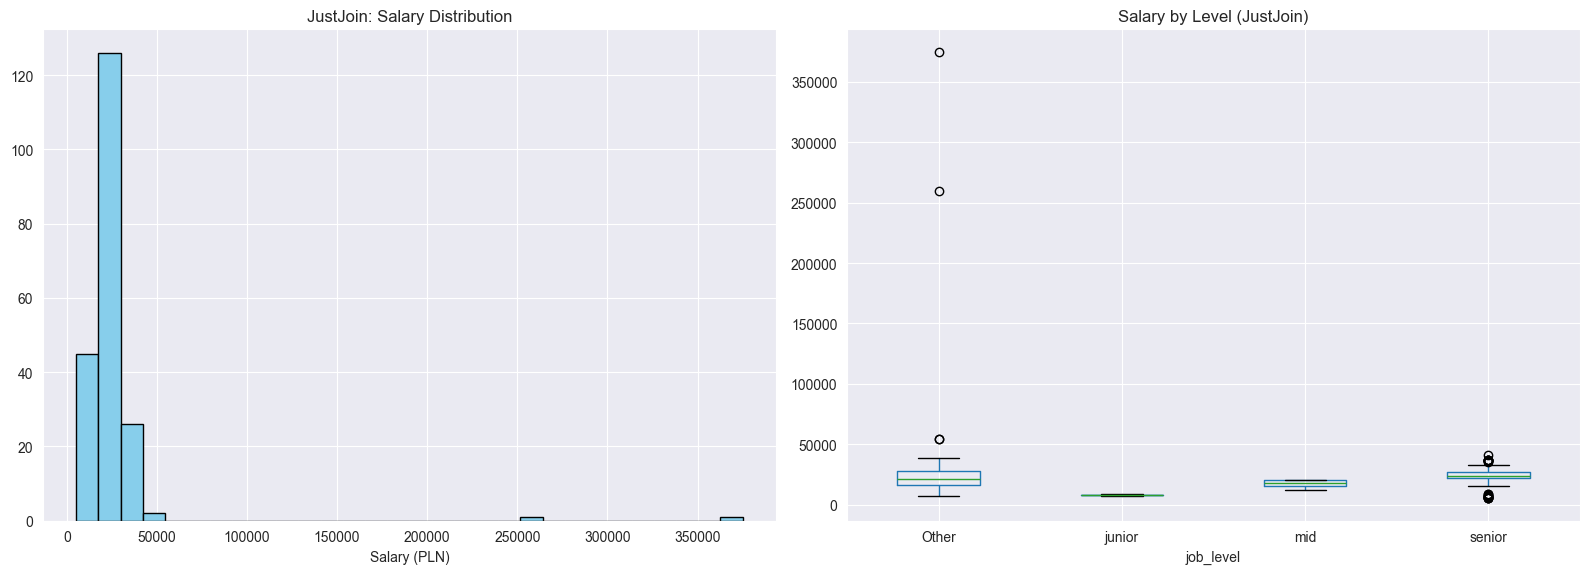


--- Result: NoFluffJobs ---
MAE: 8800.11 PLN
R²: -0.22


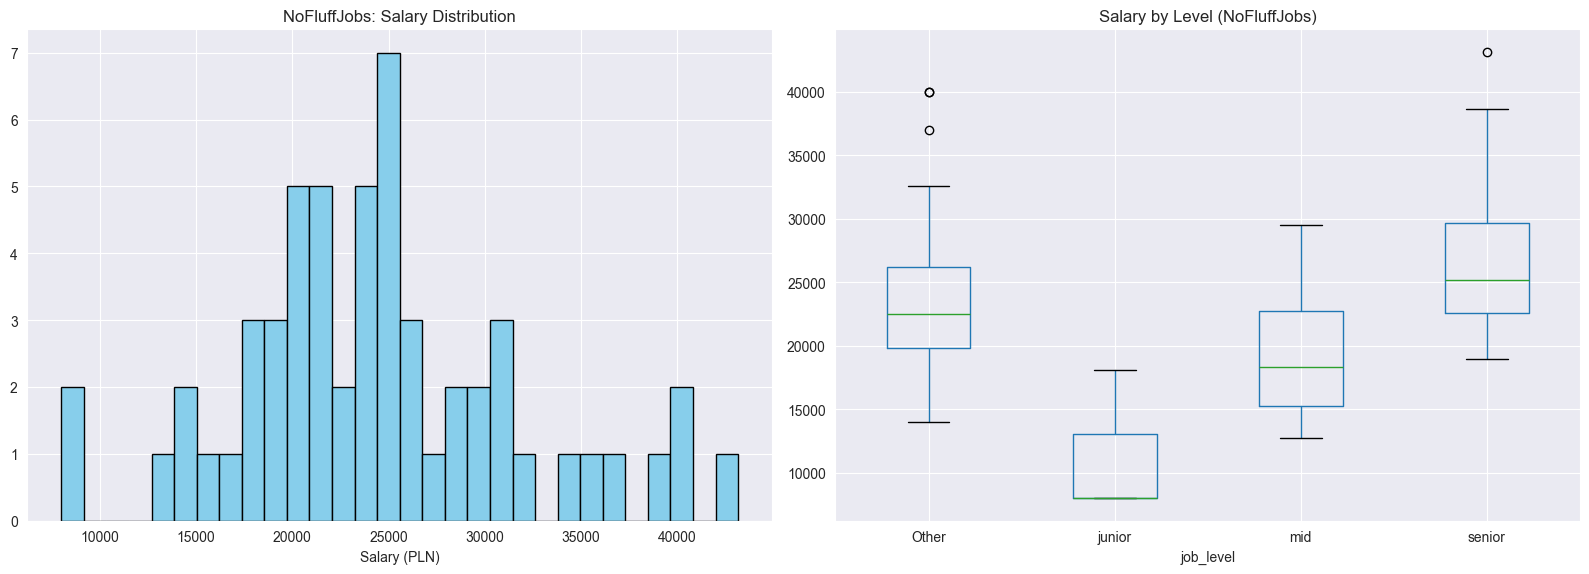

In [31]:
# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from enum import Enum
# from pymongo import MongoClient
# from dotenv import load_dotenv
#
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, r2_score
#
# # Configuration for platform collections
# class CollectionEnum(Enum):
#     JUST_JOIN = "JustJoin"
#     NO_FLUFF_JOBS = "NoFluffJobs"
#
# class SalaryModelManager:
#     def __init__(self):
#         """
#         Initialize the manager by automatically connecting to the database
#         using environment variables.
#         """
#         load_dotenv()
#         self.db = self._init_db()
#         self.categorical_features = ["location", "source", "job_level"]
#
#     def _init_db(self):
#         """
#         Internal method to establish connection with MongoDB (Atlas or Local).
#         """
#         mode = os.getenv("MONGO_MODE", "local")
#         db_name = os.getenv("DB_NAME", "BD_final")
#
#         if mode == "atlas":
#             uri = os.getenv("ATLAS_MONGO_URI")
#             if not uri:
#                 raise ValueError("❌ ATLAS_MONGO_URI not found in .env")
#             print(f"🌐 Connecting to MongoDB Atlas...")
#         else:
#             uri = "mongodb://localhost:27017/"
#             print(f"🏠 Connecting to Local MongoDB...")
#
#         try:
#             client = MongoClient(uri)
#             # Send a ping to confirm a successful connection
#             client.admin.command('ping')
#             print(f"✅ Successfully connected to database: {db_name}")
#             return client[db_name]
#         except Exception as e:
#             print(f"❌ Database connection failed: {e}")
#             raise
#
#     @staticmethod
#     def _categorize_job_level(title):
#         """
#         Internal helper to map job titles to seniority levels.
#         """
#         title = str(title).lower()
#         if "senior" in title:
#             return "senior"
#         if "junior" in title:
#             return "junior"
#         if "mid" in title or "regular" in title:
#             return "mid"
#         return "Other"
#
#     def _fetch_and_clean_data(self, platform_name):
#         """
#         Retrieve data from MongoDB and perform initial cleaning/feature engineering.
#         """
#         if platform_name == CollectionEnum.JUST_JOIN:
#             data = list(self.db.jobs_processed_jj.find())
#         elif platform_name == CollectionEnum.NO_FLUFF_JOBS:
#             data = list(self.db.jobs_processed.find())
#         else:
#             raise NameError(f"Collection for {platform_name} not found.")
#
#         df = pd.DataFrame(data)
#
#         # Select and validate required columns
#         required_cols = ["source", "job_title", "min_salary", "max_salary", "location"]
#         df = df[[col for col in required_cols if col in df.columns]]
#
#         # Clean salary data
#         df = df.dropna(subset=["min_salary", "max_salary"])
#         df["avg_salary"] = (df["min_salary"] + df["max_salary"]) / 2
#
#         # Engineering the 'job_level' feature
#         df["job_level"] = df["job_title"].apply(self._categorize_job_level)
#
#         return df
#
#     def train_and_evaluate(self, platform_name):
#         """
#         Main pipeline: Load data, train RandomForest model, and print metrics.
#         """
#         df = self._fetch_and_clean_data(platform_name)
#
#         if df.empty:
#             print(f"⚠️ No data available for {platform_name.value}. Skipping...")
#             return None
#
#         X = df[self.categorical_features]
#         y = df["avg_salary"]
#
#         # Build Pipeline
#         preprocessor = ColumnTransformer(
#             transformers=[
#                 ("cat", OneHotEncoder(handle_unknown="ignore"), self.categorical_features)
#             ]
#         )
#
#         model_pipeline = Pipeline(steps=[
#             ("preprocessor", preprocessor),
#             ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
#         ])
#
#         # Split and Train
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#         model_pipeline.fit(X_train, y_train)
#
#         # Evaluation
#         y_pred = model_pipeline.predict(X_test)
#         print(f"\n--- Result: {platform_name.value} ---")
#         print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} PLN")
#         print(f"R²: {r2_score(y_test, y_pred):.2f}")
#
#         # Visualization
#         self._run_visualizations(df, platform_name)
#
#         return model_pipeline
#
#     def _run_visualizations(self, df, platform_name):
#         """
#         Generates statistical plots.
#         """
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
#
#         # Histogram
#         ax1.hist(df["avg_salary"], bins=30, color='skyblue', edgecolor='black')
#         ax1.set_title(f"{platform_name.value}: Salary Distribution")
#         ax1.set_xlabel("Salary (PLN)")
#
#         # Boxplot
#         df.boxplot(column="avg_salary", by="job_level", ax=ax2)
#         ax2.set_title(f"Salary by Level ({platform_name.value})")
#         plt.suptitle("") # Clear automatic title
#
#         plt.tight_layout()
#         plt.show()
#
#
#
# # The class now handles everything upon instantiation
# manager = SalaryModelManager()
#
# for platform in [CollectionEnum.JUST_JOIN, CollectionEnum.NO_FLUFF_JOBS]:
#     manager.train_and_evaluate(platform)